In [1]:
import sys
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt
from adjoint_esn.esn import ESN
from adjoint_esn.rijke_esn import RijkeESN
from adjoint_esn.utils import preprocessing as pp
from adjoint_esn.utils.enums import eParam, get_eVar
from pathlib import Path
from adjoint_esn.utils import signals as sig
import adjoint_esn.utils.visualizations as vis
from adjoint_esn.utils import errors
from scipy import signal
from functools import partial
import yaml
from adjoint_esn.validation import set_ESN
from adjoint_esn.utils.discretizations import finite_differences
import adjoint_esn.utils.solve_ode as solve_ode

In [2]:
# create linear model, AX = B
input_dim = 1
output_dim = 1
n = 20000
X = np.random.randn(input_dim, output_dim)
A = np.random.randn(n, input_dim)
B = A @ X
A_noisy = A + 0.2 * np.random.randn(n, input_dim)
B_noisy = B + 0.2 * np.random.randn(n, output_dim)

print('True X:', X)
for n_train in [10,100,1000,5000,10000,15000,20000]:
    print('N train:', n_train)
    A_train = A_noisy[:n_train]
    B_train = B_noisy[:n_train]

    AA = A_train.T @ A_train
    f = A_train.T @ B_train
    X_ols = np.linalg.solve(AA,f)
    print('X ols:', X_ols,'Error:',np.linalg.norm(B - A @ X_ols))

    C = np.hstack([A_train, B_train])
    U, S, Vh = np.linalg.svd(C)
    V = Vh.T
    V11 = V[:input_dim,:input_dim]
    V12 = V[:input_dim,input_dim:]
    V21 = V[input_dim:,:input_dim]
    V22 = V[input_dim:,input_dim:]
    S1 = S[:input_dim]
    S2 = S[input_dim:]

    X_tls = -V12 @ np.linalg.inv(V22)
    print('X tls:', X_tls,'Error:',np.linalg.norm(B - A @ X_tls))

    X_ridge = np.linalg.solve(AA-V22**2*np.eye(output_dim),f)
    print('X ridge:', X_ridge,'Error:',np.linalg.norm(B - A @ X_ridge))

True X: [[0.00149653]]
N train: 10
X ols: [[-0.0075351]] Error: 1.2768839470351199
X tls: [[-0.00786082]] Error: 1.3229337656246296
X ridge: [[-0.00896426]] Error: 1.4789378680471488
N train: 100
X ols: [[-0.00044195]] Error: 0.2740604001234514
X tls: [[-0.00046238]] Error: 0.27694834800353313
X ridge: [[-0.0004465]] Error: 0.2747033719738781
N train: 1000
X ols: [[-0.00693777]] Error: 1.19243472804338
X tls: [[-0.0072503]] Error: 1.2366194646349904
X ridge: [[-0.00694513]] Error: 1.193474381840779
N train: 5000
X ols: [[-0.00063254]] Error: 0.3010060110618995
X tls: [[-0.00065804]] Error: 0.3046110394339679
X ridge: [[-0.00063266]] Error: 0.3010232882289898
N train: 10000
X ols: [[-0.00178606]] Error: 0.46408951266386583
X tls: [[-0.00185837]] Error: 0.4743132039271549
X ridge: [[-0.00178623]] Error: 0.46411379767517863
N train: 15000
X ols: [[-0.00011972]] Error: 0.22850366355915847
X tls: [[-0.00012453]] Error: 0.22918388839680434
X ridge: [[-0.00011973]] Error: 0.22850474318606157


## Load config

In [2]:
def load_config(experiment_path):
       with open(experiment_path/'config.yml', 'r') as file:
         config = yaml.unsafe_load(file)
         return config

experiment_path=Path('../local_results/rijke/run_20231029_153121') # no noise

config = load_config(experiment_path)
results = pp.unpickle_file(experiment_path / 'results.pickle')[0]
print(config)
print(results)

model:
  connectivity: 20
  input_only_mode: false
  input_vars: eta_mu_v_tau
  input_weights_mode: sparse_grouped_rijke
  network_dt: 0.01
  output_vars: eta_mu
  param_vars:
  - beta
  r2_mode: false
  reservoir_size: 1200
  reservoir_weights_mode: erdos_renyi1
  type: rijke
  u_f_order: 1
  washout_time: 4
random_seed: 41
simulation:
  N_g: 4
  beta_list:
  - 1.0
  - 2.0
  - 3.0
  - 4.0
  - 5.0
  noise_level: 0
  sim_dt: 0.001
  sim_time: 800
  tau_list:
  - 0.1
  - 0.15
  - 0.2
  - 0.25
  - 0.3
  transient_time: 200
train:
  regime_selection: 20
  tikhonov: 0.001
  time: 8
val:
  error_measure: rel_L2
  fold_time: 4
  hyperparameters:
    input_scaling:
      max: 5.0
      min: 0.01
      scale: log10
    leak_factor:
      max: 1.0
      min: 0.01
      scale: log10
    parameter_normalization_mean:
      beta:
        max: 10.0
        min: -10.0
        scale: uniform
    parameter_normalization_var:
      beta:
        max: 10.0
        min: 0.01
        scale: log10
    spect

## Generate clean data

In [3]:
integrator = 'odeint'

# number of galerkin modes
N_g = config.simulation.N_g

# simulation options
sim_time = config.simulation.sim_time
sim_dt = config.simulation.sim_dt

# directory to search for simulation data, if the data doesn't exist, 
# then it will simulate the system
data_dir=Path('..\data')

# which regimes to use for training and validation
train_param_list = results["training_parameters"]
# Create the mesh to get the data from
param_mesh_input = [None] * 2
param_mesh_input[eParam.beta] = [7.2]
param_mesh_input[eParam.tau] = [0.2]
train_param_list= pp.make_param_mesh(param_mesh_input)

train_idx_list = np.arange(len(train_param_list))

transient_time = config.simulation.transient_time

# network time step
network_dt = config.model.network_dt

washout_time = config.model.washout_time

# which states to use as input and output
# for standard ESN these should be the same, e.g. both 'eta_mu'
# for Rijke ESN, input and output should be 'eta_mu_v_tau' and 'eta_mu' respectively
input_vars = config.model.input_vars
eInputVar = get_eVar(input_vars,N_g)
output_vars = config.model.output_vars
eOutputVar = get_eVar(output_vars,N_g)

# which system parameter is passed to the ESN
param_vars=config.model.param_vars

# if using Rijke ESN what is the order of u_f(t-tau) in the inputs,
# [u_f(t-tau), u_f(t-tau)^2 ..., u_f(t-tau)^(u_f_order)]
u_f_order = config.model.u_f_order

# length of training time series
train_time = 1 #config.train.time
val_time = config.train.time

loop_names=['train']
loop_times = [train_time]

DATA_clean = {}
for loop_name in loop_names:
    DATA_clean[loop_name]={'u_washout':[],'p_washout':[],'u':[],'p':[],'y':[],'t':[]}

for p_idx, p in enumerate(train_param_list):
    p_sim = {'beta':p[eParam.beta], 'tau':p[eParam.tau]}
    y_sim, t_sim = pp.load_data(beta=p_sim["beta"],tau=p_sim["tau"],x_f=0.2,N_g=N_g,
                                sim_time=sim_time,sim_dt=sim_dt,
                                data_dir=data_dir,integrator=integrator)

    regime_data = pp.create_dataset(y_sim,t_sim,p_sim,
                        network_dt=network_dt,
                        transient_time=transient_time,
                        washout_time=washout_time,
                        loop_times=loop_times,
                        loop_names=loop_names,
                        input_vars=input_vars,
                        output_vars=output_vars,
                        param_vars=param_vars,
                        N_g=N_g,
                        u_f_order=u_f_order,
                        noise_level=0.0,
                        tau=p_sim["tau"])
    
    for loop_name in loop_names:
        [DATA_clean[loop_name][var].append(regime_data[loop_name][var]) for var in DATA_clean[loop_name].keys()]

dim = DATA_clean["train"]["u"][0].shape[1]

## Generate noisy data

In [4]:
noise_level = 5.0
n_seeds = 1

DATA_list = [None]*n_seeds
for s_idx in range(n_seeds):
    DATA_list[s_idx] = {}
    for loop_name in loop_names:
        DATA_list[s_idx][loop_name]={'u_washout':[],'p_washout':[],'u':[],'p':[],'y':[],'t':[]}

for p_idx, p in enumerate(train_param_list):
    p_sim = {'beta':p[eParam.beta], 'tau':p[eParam.tau]}
    y_sim, t_sim = pp.load_data(beta=p_sim["beta"],tau=p_sim["tau"],x_f=0.2,N_g=N_g,
                                sim_time=sim_time,sim_dt=sim_dt,
                                data_dir=data_dir,integrator=integrator)

    for s_idx in range(n_seeds):
        regime_data = pp.create_dataset(y_sim,t_sim,p_sim,
                            network_dt=network_dt,
                            transient_time=transient_time,
                            washout_time=washout_time,
                            loop_times=loop_times,
                            loop_names=loop_names,
                            input_vars=input_vars,
                            output_vars=output_vars,
                            param_vars=param_vars,
                            N_g=N_g,
                            u_f_order=u_f_order,
                            noise_level=noise_level,
                            random_seed=None,
                            tau=p_sim["tau"])
        
        for loop_name in loop_names:
            [DATA_list[s_idx][loop_name][var].append(regime_data[loop_name][var]) for var in DATA_list[s_idx][loop_name].keys()]


In [4]:
DATA_list = pp.unpickle_file('noisy_data.pickle')[0]

## Train with clean

In [5]:
def create_ESN(ESN_dict, model_type, hyp_param_names, hyp_param_scales, hyp_params):
    if model_type == 'standard':
        my_ESN = ESN(**ESN_dict)
    elif model_type == 'rijke':
        my_ESN = RijkeESN(**ESN_dict)
    set_ESN(my_ESN,hyp_param_names,hyp_param_scales,hyp_params)
    return my_ESN

ESN_dict = {
        "reservoir_size": config.model.reservoir_size,
        "parameter_dimension": len(param_vars),
        "reservoir_connectivity": config.model.connectivity,
        "r2_mode": config.model.r2_mode,
        "input_only_mode": config.model.input_only_mode,
        "input_weights_mode": config.model.input_weights_mode,
        "reservoir_weights_mode": config.model.reservoir_weights_mode,
        "tikhonov": config.train.tikhonov,
        "verbose":False
    }
if config.model.type == "standard":
    ESN_dict["dimension"] = dim
elif config.model.type == "rijke":
    ESN_dict["N_g"] = config.simulation.N_g
    ESN_dict["x_f"] = 0.2
    ESN_dict["dt"] = config.model.network_dt
    ESN_dict["u_f_order"] = config.model.u_f_order

print('System dimension: ', dim)

top_idx = 0
hyp_param_names = []
hyp_params = []
for name in results.keys():
    if name not in ['training_parameters','validation_parameters','f','tikh']:
        if results[name].ndim == 2:
            hyp_param_names.extend([name]*results[name].shape[1])
            hyp_params.extend(results[name][top_idx])
        elif results[name].ndim == 1:
            hyp_param_names.extend([name])
            hyp_params.extend([results[name][top_idx]])
        
hyp_param_scales = ['uniform']*len(hyp_param_names)
# expand the ESN dict with the fixed seeds
ESN_dict["input_seeds"] = [20,21,22]
ESN_dict["reservoir_seeds"] = [23,24]
my_ESN_clean = create_ESN(ESN_dict, config.model.type, hyp_param_names, hyp_param_scales, hyp_params)

my_ESN_clean.train(DATA_clean["train"]["u_washout"], 
             DATA_clean["train"]["u"], 
             DATA_clean["train"]["y"],
             P_washout=DATA_clean["train"]["p_washout"], 
             P_train=DATA_clean["train"]["p"],
             train_idx_list=train_idx_list)
W_out_clean = my_ESN_clean.W_out

System dimension:  9


## Train with noisy

In [6]:
W_out_list = [None]*n_seeds
for s_idx in range(n_seeds):
    my_ESN = create_ESN(ESN_dict, config.model.type, hyp_param_names, hyp_param_scales, hyp_params)
    my_ESN.train(DATA_list[s_idx]["train"]["u_washout"], 
                DATA_list[s_idx]["train"]["u"], 
                DATA_list[s_idx]["train"]["y"],
                P_washout=DATA_list[s_idx]["train"]["p_washout"], 
                P_train=DATA_list[s_idx]["train"]["p"],
                train_idx_list=train_idx_list)
    W_out_list[s_idx] = my_ESN.W_out
W_out_list = np.array(W_out_list)

## How about ensemble of ESNs?

In [7]:
which_train_idx = 0
my_ESN_clean.tau = results["training_parameters"][which_train_idx][1]
x_clean = my_ESN_clean.open_loop_with_washout(U_washout=DATA_clean["train"]["u_washout"][which_train_idx],P_washout=DATA_clean["train"]["p_washout"][which_train_idx],
                           U=DATA_clean["train"]["u"][which_train_idx],P=DATA_clean["train"]["p"][which_train_idx],)
y_clean = np.matmul(x_clean,my_ESN_clean.W_out)
_, y_cl_clean = my_ESN_clean.closed_loop_with_washout(U_washout=DATA_clean["train"]["u_washout"][which_train_idx],P_washout=DATA_clean["train"]["p_washout"][which_train_idx],
                            N_t=len(DATA_clean["train"]["u"][which_train_idx]),P=DATA_clean["train"]["p"][which_train_idx],)

In [ ]:
# Different seeds
y = [None]*n_seeds
for s_idx in range(n_seeds):
    ESN_dict["input_seeds"] = [None,None,None]
    ESN_dict["reservoir_seeds"] = [None,None]
    my_ESN = create_ESN(ESN_dict, config.model.type, hyp_param_names, hyp_param_scales, hyp_params)
    my_ESN.train(DATA_list[0]["train"]["u_washout"], 
                DATA_list[0]["train"]["u"], 
                DATA_list[0]["train"]["y"],
                P_washout=DATA_list[0]["train"]["p_washout"], 
                P_train=DATA_list[0]["train"]["p"],
                train_idx_list=train_idx_list)
    my_ESN.tau = results["training_parameters"][which_train_idx][1]
    x = my_ESN.open_loop_with_washout(U_washout=DATA_clean["train"]["u_washout"][which_train_idx],P_washout=DATA_clean["train"]["p_washout"][which_train_idx],
                            U=DATA_clean["train"]["u"][which_train_idx],P=DATA_clean["train"]["p"][which_train_idx],)
    y[s_idx] = np.matmul(x,my_ESN.W_out)

In [47]:
W_out_list = pp.unpickle_file('noisy_uy_W_out.pickle')[0]

In [8]:
# Different noise
my_ESN.tau = results["training_parameters"][which_train_idx][1]
y_ol = [None]*len(W_out_list)
y_cl = [None]*len(W_out_list)
for s_idx in range(10):
    y_ol[s_idx] = np.matmul(x_clean,W_out_list[s_idx])
    my_ESN.W_out = W_out_list[s_idx]
    _,y_cl[s_idx] = my_ESN.closed_loop_with_washout(U_washout=DATA_clean["train"]["u_washout"][which_train_idx],P_washout=DATA_clean["train"]["p_washout"][which_train_idx],
                            N_t=len(DATA_clean["train"]["u"][which_train_idx]),P=DATA_clean["train"]["p"][which_train_idx],)
W_out_mean = np.mean(W_out_list,axis=0)
y_ol_mean = np.matmul(x_clean,W_out_mean)
my_ESN.W_out = W_out_mean
_, y_cl_mean = my_ESN.closed_loop_with_washout(U_washout=DATA_clean["train"]["u_washout"][which_train_idx],P_washout=DATA_clean["train"]["p_washout"][which_train_idx],
                            N_t=len(DATA_clean["train"]["u"][which_train_idx]),P=DATA_clean["train"]["p"][which_train_idx],)

Text(0, 0.5, 'eta 1')

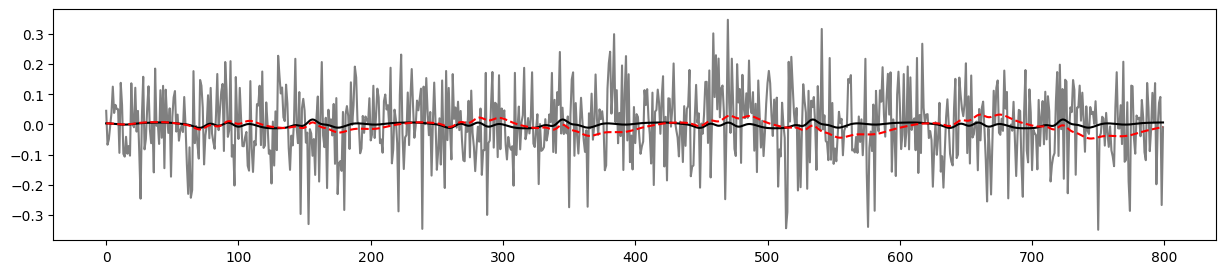

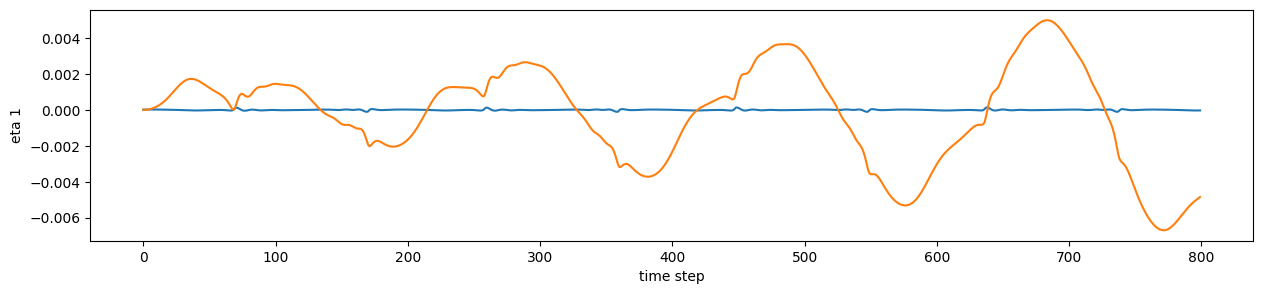

In [21]:
which_var = 0
plt.figure(figsize=(15,3))
# plt.plot(DATA_list[0]["train"]["y"][which_train_idx][:,0])
# plt.plot(DATA_clean["train"]["y"][which_train_idx][:,0])
# plt.plot(y_clean[:,0])
for s_idx in range(1):
    plt.plot(DATA_list[s_idx]["train"]["y"][which_train_idx][:,which_var]-y_ol[s_idx][1:,which_var],'-',color='grey')
    plt.plot(DATA_clean["train"]["y"][which_train_idx][:,which_var]-y_ol[s_idx][1:,which_var],'k-')
    plt.plot(DATA_clean["train"]["y"][which_train_idx][:,which_var]-y_cl[s_idx][1:,which_var],'r--')

# plt.plot(DATA_clean["train"]["y"][which_train_idx][:,0]-np.mean(np.array(y),axis=0)[1:,0])
# plt.plot(DATA_clean["train"]["y"][which_train_idx][:,which_var]-y_ol_mean[1:,which_var],'r-')
# plt.plot(DATA_clean["train"]["y"][which_train_idx][:,which_var]-y_cl_mean[1:,which_var],'g-')

plt.figure(figsize=(15,3))
plt.plot(DATA_clean["train"]["y"][which_train_idx][:,which_var]-y_clean[1:,which_var])
plt.plot(DATA_clean["train"]["y"][which_train_idx][:,which_var]-y_cl_clean[1:,which_var])

plt.xlabel('time step')
plt.ylabel('eta 1')

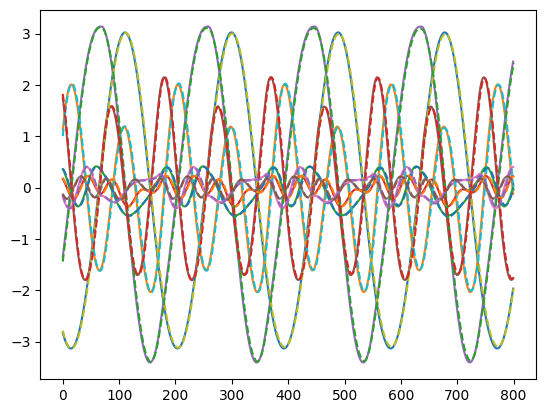

In [10]:
plt.plot(DATA_clean["train"]["y"][which_train_idx])
plt.plot(y_cl[0],'--')

Text(0, 0.5, 'eta 1')

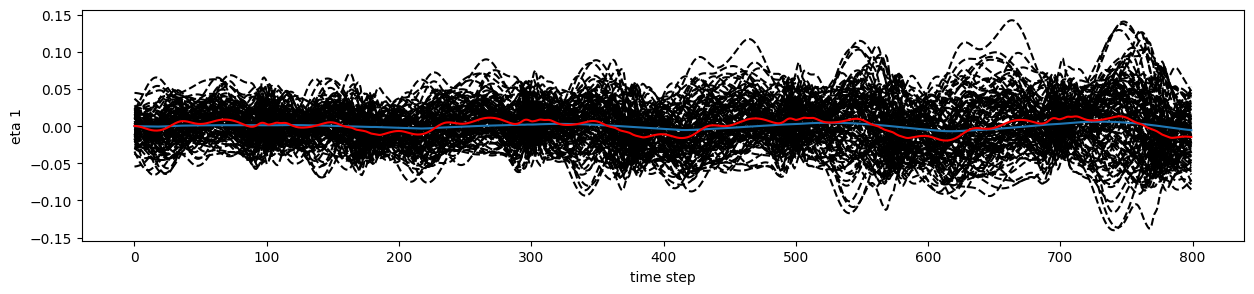

In [63]:
which_var = 0
plt.figure(figsize=(15,3))
for s_idx in range(100):
    plt.plot(DATA_clean["train"]["y"][which_train_idx][:,which_var]-y_cl[s_idx][1][1:,which_var],'k--')
plt.plot(DATA_clean["train"]["y"][which_train_idx][:,which_var]-y_cl_clean[1][1:,which_var])
plt.plot(DATA_clean["train"]["y"][which_train_idx][:,which_var]-y_cl_mean[1][1:,which_var],'r-')
plt.xlabel('time step')
plt.ylabel('eta 1')

In [23]:
W_out_list = [None]*n_seeds
for s_idx in range(n_seeds):
    my_ESN = create_ESN(ESN_dict, config.model.type, hyp_param_names, hyp_param_scales, hyp_params)
    my_ESN.train(DATA_clean["train"]["u_washout"], 
                DATA_clean["train"]["u"], 
                DATA_list[s_idx]["train"]["y"],
                P_washout=DATA_clean["train"]["p_washout"], 
                P_train=DATA_clean["train"]["p"],
                train_idx_list=train_idx_list)
    W_out_list[s_idx] = my_ESN.W_out
W_out_list = np.array(W_out_list)

## Compare statistics of noisy $W_{out}$ with clean $W_{out}$

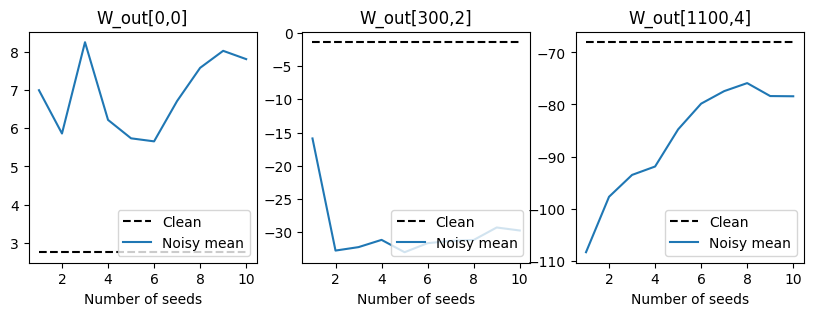

In [39]:
r_idxs = [0,300,1100]
y_idxs = [0, 2, 4]
i = 0
plt.figure(figsize=(10,3))
for r_idx, y_idx in zip(r_idxs,y_idxs):
    i += 1
    plt.subplot(1,3,i)
    W_out_cum = (1/np.arange(1,n_seeds+1)) * np.cumsum(W_out_list[:,r_idx,y_idx])
    plt.hlines(W_out_clean[r_idx,y_idx], xmin=1, xmax=n_seeds, color='k', linestyle='--')
    plt.plot(np.arange(1,n_seeds+1),W_out_cum)
    plt.xlabel('Number of seeds')
    plt.title(f'W_out[{r_idx},{y_idx}]')
    plt.legend(['Clean','Noisy mean'],loc='lower right')

In [40]:
W_out_mean = np.mean(W_out_list,axis=0)
W_out_std = np.std(W_out_list,axis=0)

In [41]:
print(f"Clean W_out[{r_idx},{y_idx}]: {W_out_clean[r_idx,y_idx]}")
print(f"Mean W_out[{r_idx},{y_idx}]: {W_out_mean[r_idx,y_idx]}")
print(f"Std W_out[{r_idx},{y_idx}]: {W_out_std[r_idx,y_idx]}")

Clean W_out[1100,4]: -68.04453151681075
Mean W_out[1100,4]: -78.42778339092419
Std W_out[1100,4]: 17.137563300063476


In [42]:
R = np.empty((0, my_ESN_clean.W_out_shape[0]))
for train_idx in train_idx_list:
    X_train_augmented_ = my_ESN_clean.reservoir_for_train(
        DATA_clean["train"]["u_washout"][train_idx],
        DATA_clean["train"]["u"][train_idx],
        DATA_clean["train"]["p_washout"][train_idx],
        DATA_clean["train"]["p"][train_idx],
    )
    R = np.vstack((R, X_train_augmented_))

In [43]:
Y_train = [DATA_clean["train"]["y"][train_idx] for train_idx in train_idx_list]
Y_train = np.vstack(Y_train)

In [44]:
# get the standard deviation of noise
std_list = np.zeros((len(train_idx_list),DATA_clean["train"]["y"][0].shape[1]))
for train_idx in train_idx_list:
    std_list[train_idx] = noise_level/100*np.std(DATA_clean["train"]["y"][train_idx],axis=0)
# this is different for each regime
# we need to concatenate and make a diagonal matrix

In [45]:
y_idx = 0
epsilon = np.diag(np.repeat(std_list[:,y_idx]**2,DATA_clean["train"]["y"][0].shape[0]))

RR = np.matmul(R.T,R)
phi = RR+my_ESN_clean.tikhonov*np.eye(my_ESN_clean.N_reservoir)
f = np.matmul(R.T, Y_train)
cov1 = np.linalg.solve(phi,R.T)
cov = cov1 @ epsilon @ cov1.T

# cov12 = np.linalg.inv(phi)
# cov2 = cov12 @ R.T @ epsilon @ R @ cov12

W_out_cov = np.cov(W_out_list[:,:,y_idx].T)

In [46]:
R_noisy = np.empty((0, my_ESN_clean.W_out_shape[0]))
for train_idx in train_idx_list:
    X_train_augmented_ = my_ESN_clean.reservoir_for_train(
        DATA_list[0]["train"]["u_washout"][train_idx],
        DATA_list[0]["train"]["u"][train_idx],
        DATA_list[0]["train"]["p_washout"][train_idx],
        DATA_list[0]["train"]["p"][train_idx],
    )
    R_noisy = np.vstack((R_noisy, X_train_augmented_))

Text(0.5, 0, 'Output state')

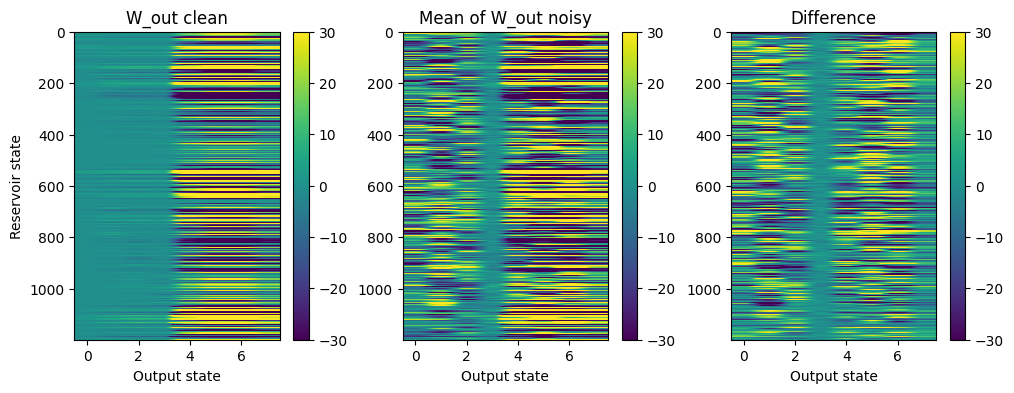

In [47]:
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.imshow(W_out_clean, aspect=0.01, vmin=-30, vmax=30)
plt.colorbar()
plt.title("W_out clean")
plt.ylabel('Reservoir state')
plt.xlabel('Output state')
plt.subplot(1,3,2)
plt.imshow(W_out_mean, aspect=0.01, vmin=-30, vmax=30)
plt.colorbar()
plt.title("Mean of W_out noisy")
plt.xlabel('Output state')
plt.subplot(1,3,3)
plt.imshow(W_out_clean-W_out_mean, aspect=0.01, vmin=-30, vmax=30)
plt.colorbar()
plt.title("Difference")
plt.xlabel('Output state')

Text(0.5, 0, 'Reservoir state')

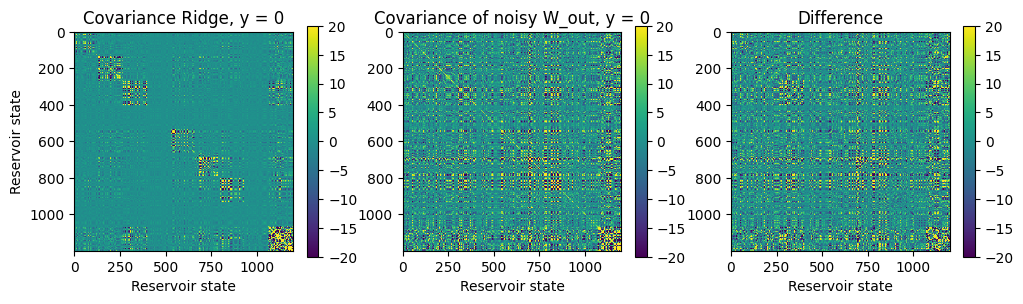

In [48]:
plt.figure(figsize=(12,3))
plt.subplot(1,3,1)
plt.imshow(cov,vmin=-20,vmax=20)
plt.colorbar()
plt.title(f'Covariance Ridge, y = {y_idx}')
plt.xlabel('Reservoir state')
plt.ylabel('Reservoir state')
plt.subplot(1,3,2)
plt.imshow(W_out_cov,vmin=-20,vmax=20)
plt.colorbar()
plt.title(f'Covariance of noisy W_out, y = {y_idx}')
plt.xlabel('Reservoir state')
plt.subplot(1,3,3)
plt.imshow(cov-W_out_cov,vmin=-20,vmax=20)
plt.colorbar()
plt.title('Difference')
plt.xlabel('Reservoir state')

## Estimating noise

In [19]:
train_idx = 0
r_clean = my_ESN_clean.open_loop(x0 = np.zeros(my_ESN_clean.N_reservoir),
                                U = DATA_clean["train"]["u"][train_idx],
                                P = DATA_clean["train"]["p"][train_idx])

In [20]:
v1 = (1-my_ESN_clean.alpha)*np.eye(my_ESN_clean.N_reservoir)+my_ESN_clean.alpha*my_ESN_clean.W.toarray()
v2 = my_ESN_clean.alpha*my_ESN_clean.W_in.toarray()[:,:-my_ESN_clean.N_param_dim]
v = np.zeros((n_seeds,len(r_clean),my_ESN_clean.N_reservoir))
for s_idx in range(n_seeds):
    e = DATA_clean["train"]["u"][train_idx]-DATA_list[s_idx]["train"]["u"][train_idx]
    for i in np.arange(1,len(r_clean)):
        v[s_idx,i,:] = v1 @ v[s_idx,i-1] + v2 @ e[i-1]

In [21]:
v_true = np.zeros((n_seeds,len(r_clean),my_ESN_clean.N_reservoir))
for s_idx in range(n_seeds):
    r_noisy = my_ESN_clean.open_loop(x0 = np.zeros(my_ESN_clean.N_reservoir),
                                U = DATA_list[s_idx]["train"]["u"][train_idx],
                                P = DATA_list[s_idx]["train"]["p"][train_idx])
    v_true[s_idx] = r_clean-r_noisy

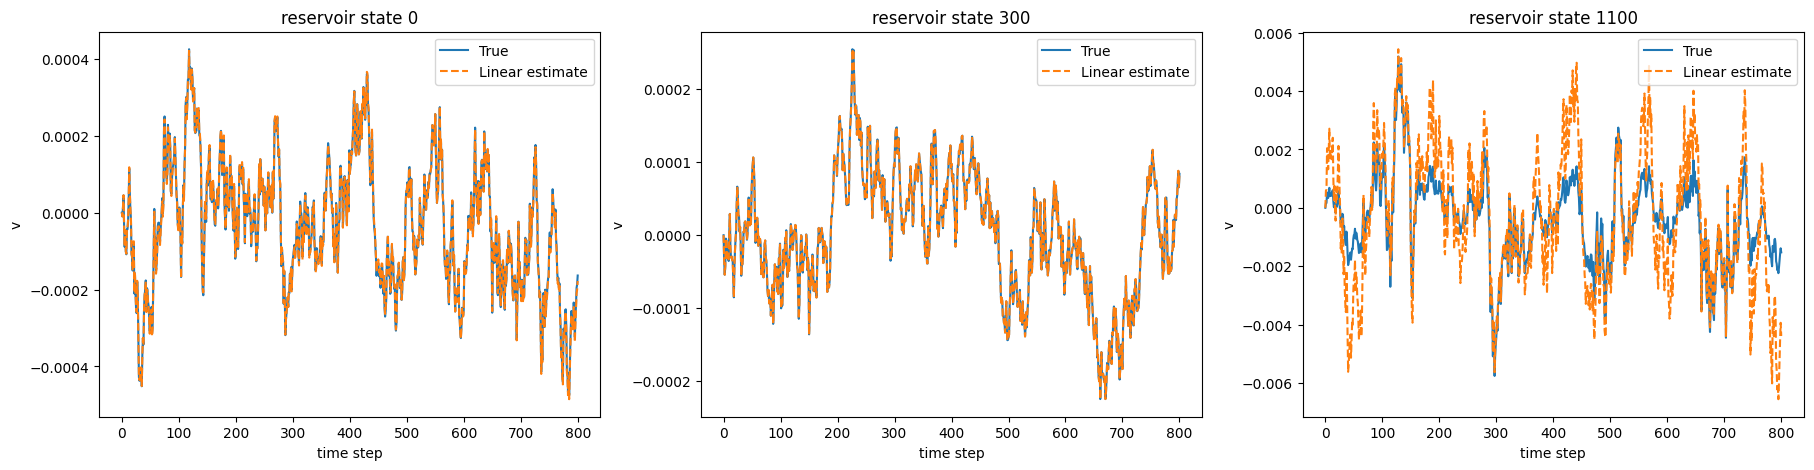

In [10]:
# compare linear noise estimation with the true
s_idx = 0
r_noisy = my_ESN_clean.open_loop(x0 = np.zeros(my_ESN_clean.N_reservoir),
                                U = DATA_list[s_idx]["train"]["u"][train_idx],
                                P = DATA_list[s_idx]["train"]["p"][train_idx])
r_idxs = [0, 300, 1100]
i = 0
plt.figure(figsize=(22,5))
for r_idx in r_idxs:
    i += 1
    plt.subplot(1,3,i)
    plt.plot(v_true[s_idx,:,r_idx])
    plt.plot(v[s_idx,:,r_idx],'--')
    plt.xlabel('time step')
    plt.ylabel('v')
    plt.title(f'reservoir state {r_idx}')
    plt.legend(['True','Linear estimate'])

In [88]:
noise = (DATA_clean["train"]["u"][train_idx]-DATA_list[0]["train"]["u"][train_idx])

In [89]:
W_in_arr = my_ESN_clean.W_in.toarray()[:,:-my_ESN_clean.N_param_dim]
pred_noise = np.zeros_like(noise)
for k in range(1,len(noise)):
    vv = v_true[0,k,:] - v1 @ v_true[0,k-1,:]
    for i in range(9):
        idx = np.where(W_in_arr[:,i] != 0)[0][0]
        pred_noise[k-1,i] = vv[idx]/(my_ESN_clean.alpha*W_in_arr[idx,i])

In [91]:
pred_noise-noise

array([[-1.67720678e-04, -4.91603612e-04,  1.74154192e-07, ...,
         4.26422357e-08, -4.28211592e-08,  1.30022219e-06],
       [ 2.31806406e-04, -5.22613604e-04,  3.88991655e-08, ...,
        -9.42620924e-08, -1.02554348e-07,  2.02902406e-05],
       [ 1.44345017e-04,  5.10933760e-04,  8.26921189e-08, ...,
        -1.55662633e-07,  9.99055340e-08,  3.49720642e-05],
       ...,
       [ 6.53153173e-05,  6.21179258e-06,  2.36451474e-07, ...,
        -8.14511943e-08, -3.97693290e-09,  3.80198295e-03],
       [ 1.15993092e-04, -4.67834203e-08,  2.56219712e-07, ...,
         4.28512173e-07, -2.55038399e-08, -1.80778124e-03],
       [ 4.34083673e-02,  6.02286287e-02,  1.06459053e-02, ...,
        -1.51523252e-02,  6.01464124e-03, -3.76587673e-02]])

In [22]:
mean_v = np.mean(v,axis=0)
std_v = np.std(v,axis=0)

# covariance is a tensor for each r, how is noise correlated at different times 
cov_v_r = np.cov(v[:,:,0].T)
# covariance is a tensor for each t, how is noise correlated at different r 
cov_v_t = np.cov(v[:,1,:].T)

In [23]:
mean_v_true = np.mean(v_true,axis=0)
std_v_true = np.std(v_true,axis=0)

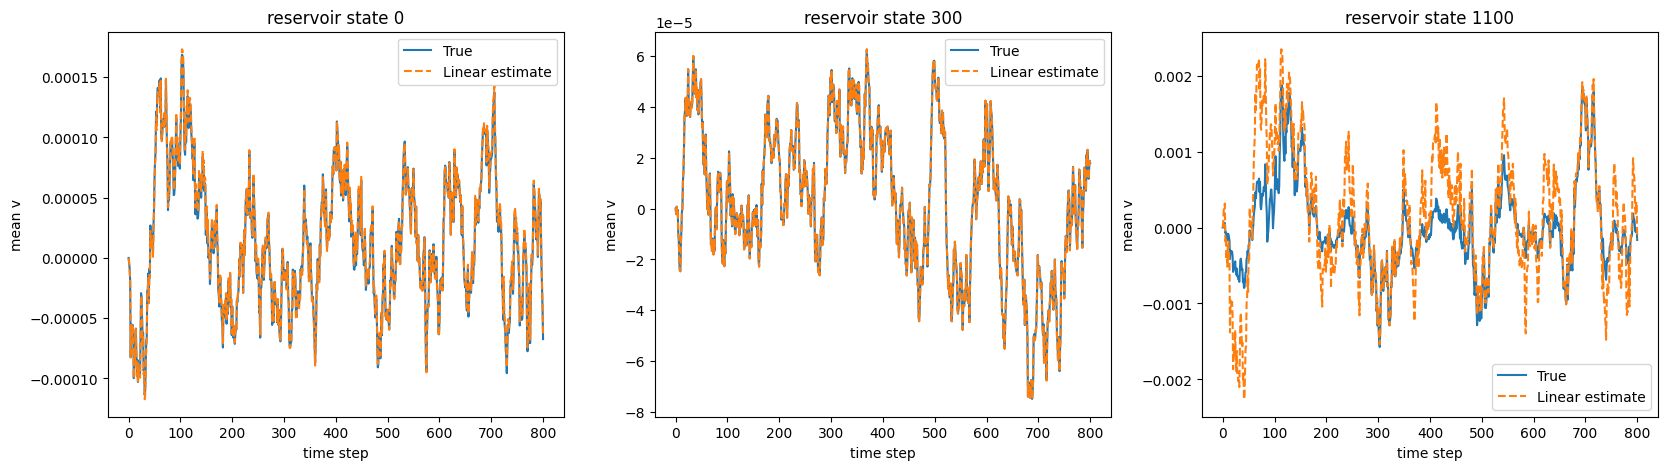

In [26]:
i = 0
r_idxs = [0,300,1100]
plt.figure(figsize=(20,5))
for r_idx in r_idxs:
    i += 1
    plt.subplot(1,3,i)
    plt.plot(mean_v_true[:,r_idx])
    plt.plot(mean_v[:,r_idx],'--')
    plt.xlabel('time step')
    plt.ylabel('mean v')
    plt.title(f'reservoir state {r_idx}')
    plt.legend(['True','Linear estimate'])

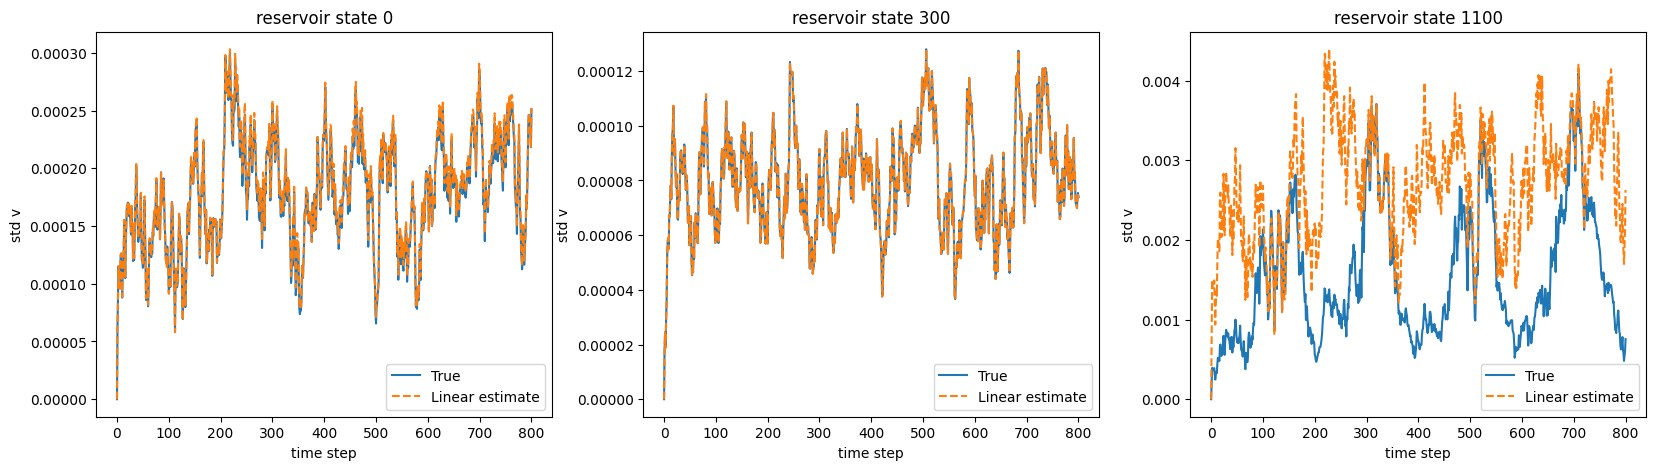

In [27]:
i = 0
plt.figure(figsize=(20,5))
for r_idx in r_idxs:
    i += 1
    plt.subplot(1,3,i)
    plt.plot(std_v_true[:,r_idx])
    plt.plot(std_v[:,r_idx],'--')
    plt.xlabel('time step')
    plt.ylabel('std v')
    plt.title(f'reservoir state {r_idx}')
    plt.legend(['True','Linear estimate'])

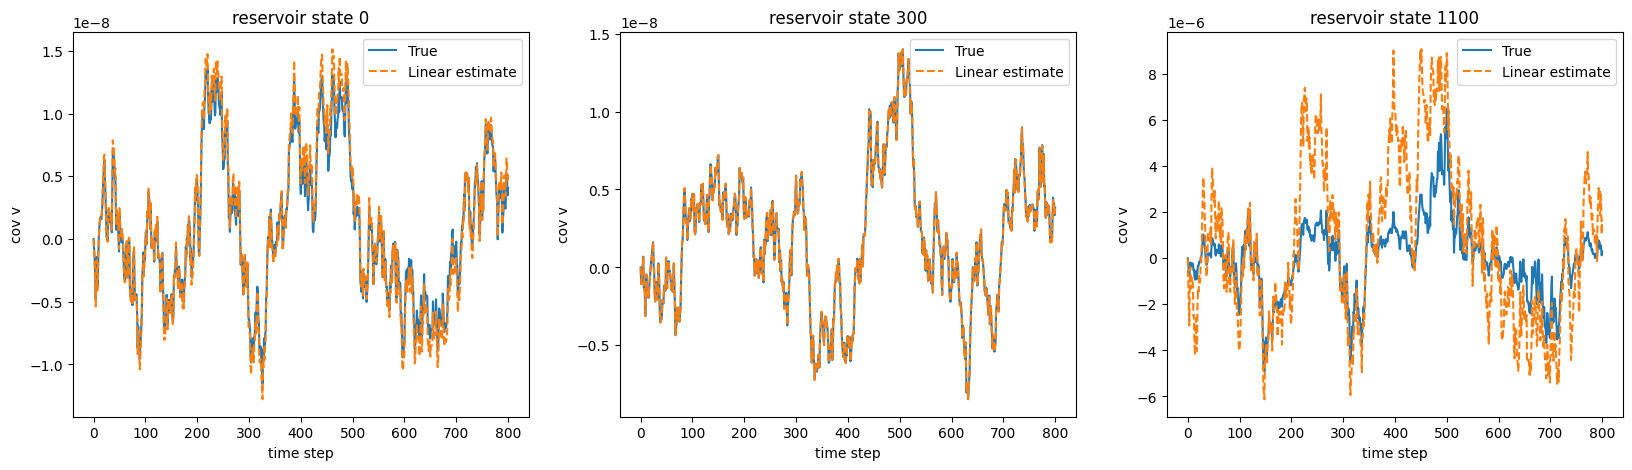

In [28]:
i = 0
plt.figure(figsize=(20,5))
for r_idx in r_idxs:
    # covariance is a tensor for each r, how is noise correlated at different times 
    cov_v_r = np.cov(v[:,:,r_idx].T)
    cov_v_true_r = np.cov(v_true[:,:,r_idx].T)
    i += 1
    plt.subplot(1,3,i)
    plt.plot(cov_v_true_r[:,500])
    plt.plot(cov_v_r[:,500],'--')
    plt.xlabel('time step')
    plt.ylabel('cov v')
    plt.title(f'reservoir state {r_idx}')
    plt.legend(['True','Linear estimate'])

## What if we average the reservoir matrices?

In [40]:
R_clean = np.empty((0, my_ESN_clean.W_out_shape[0]))
for train_idx in train_idx_list:
    X_train_augmented_ = my_ESN_clean.reservoir_for_train(
        DATA_clean["train"]["u_washout"][train_idx],
        DATA_clean["train"]["u"][train_idx],
        DATA_clean["train"]["p_washout"][train_idx],
        DATA_clean["train"]["p"][train_idx],
    )
    R_clean = np.vstack((R_clean, X_train_augmented_))

In [41]:
Y_train = [DATA_clean["train"]["y"][train_idx] for train_idx in train_idx_list]
Y_train = np.vstack(Y_train)

In [42]:
n_seeds = 10 #len(DATA_list)
R_list = [None]*10
for s_idx in range(10):
    R = np.empty((0, my_ESN_clean.W_out_shape[0]))
    for train_idx in train_idx_list:
        X_train_augmented_ = my_ESN_clean.reservoir_for_train(
            DATA_list[s_idx]["train"]["u_washout"][train_idx],
            DATA_list[s_idx]["train"]["u"][train_idx],
            DATA_list[s_idx]["train"]["p_washout"][train_idx],
            DATA_list[s_idx]["train"]["p"][train_idx],
        )
        R = np.vstack((R, X_train_augmented_))
    R_list[s_idx] = R

R_list_array = np.array(R_list)
R_mean = np.mean(R_list_array, axis = 0)

In [43]:
DATA_u_washout = [None]*10
DATA_u = [None]*10
for s_idx in range(10):
    DATA_u_washout[s_idx] = DATA_list[s_idx]["train"]["u_washout"]
    DATA_u[s_idx] = DATA_list[s_idx]["train"]["u"]
DATA_u_washout = np.mean(np.array(DATA_u_washout), axis = 0)
DATA_u = np.mean(np.array(DATA_u),axis = 0)

R_smooth = np.empty((0, my_ESN_clean.W_out_shape[0]))
for train_idx in train_idx_list:
    X_train_augmented_ = my_ESN_clean.reservoir_for_train(
        DATA_u_washout[train_idx],
        DATA_u[train_idx],
        DATA_clean["train"]["p_washout"][train_idx],
        DATA_clean["train"]["p"][train_idx],
    )
    R_smooth = np.vstack((R_smooth, X_train_augmented_))

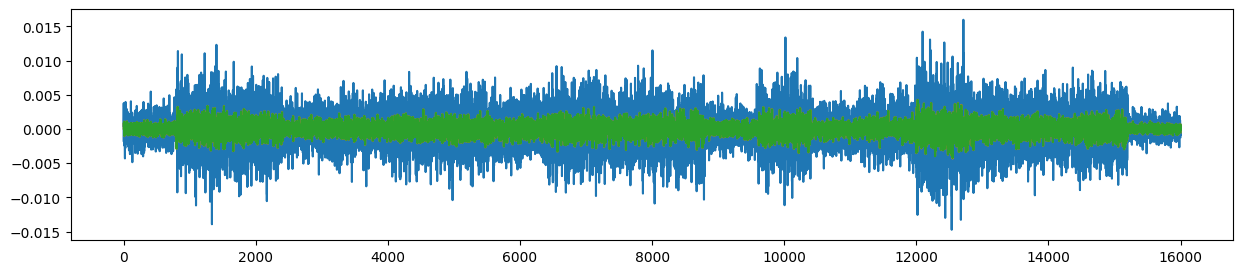

In [44]:
plt.figure(figsize=(15,3))
plt.plot(R_clean[:,0]-R_list[0][:,0])
plt.plot(R_clean[:,0]-R_mean[:,0])
plt.plot(R_clean[:,0]-R_smooth[:,0])

In [51]:
W_out_clean = my_ESN_clean.solve_ridge(R_clean,Y_train,tikh=1e-4)
W_out_noisy = my_ESN_clean.solve_ridge(R_list[0],Y_train,tikh=1e-4)
W_out_mean = my_ESN_clean.solve_ridge(R_mean,Y_train,tikh=1e-4)
W_out_smooth = my_ESN_clean.solve_ridge(R_smooth,Y_train,tikh=1e-4)

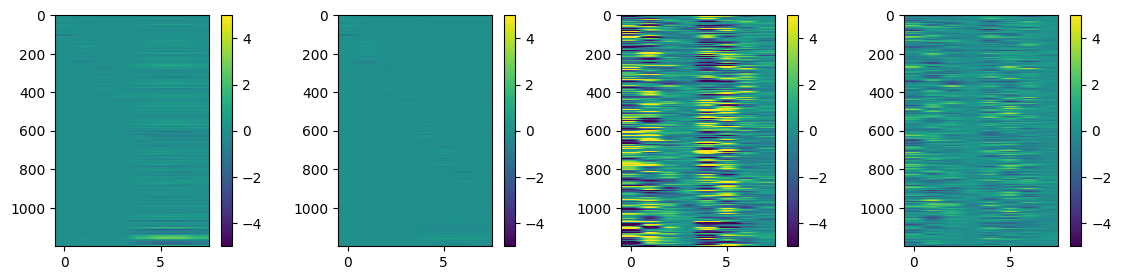

In [52]:
plt.figure(figsize=(14,3))
plt.subplot(1,4,1)
plt.imshow(my_ESN_clean.W_out,aspect=0.01,vmin=-5,vmax=5)
plt.colorbar()
plt.subplot(1,4,2)
plt.imshow(W_out_clean,aspect=0.01,vmin=-5,vmax=5)
plt.colorbar()
plt.subplot(1,4,3)
plt.imshow(W_out_noisy,aspect=0.01,vmin=-5,vmax=5)
plt.colorbar()
plt.subplot(1,4,4)
plt.imshow(W_out_smooth,aspect=0.01,vmin=-5,vmax=5)
plt.colorbar()

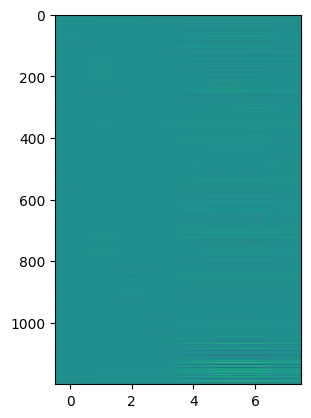

In [37]:
plt.imshow(my_ESN_clean.W_out,aspect = 0.01,vmin=-30,vmax=30)

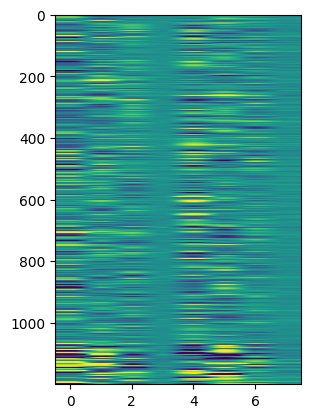

In [38]:
plt.imshow(my_ESN.W_out,aspect = 0.01,vmin=-30,vmax=30)

## try some stuff

In [271]:
R_noisy = np.empty((0, my_ESN_clean.W_out_shape[0]))
for train_idx in train_idx_list:
    X_train_augmented_ = my_ESN_clean.reservoir_for_train(
        DATA_list[0]["train"]["u_washout"][train_idx],
        DATA_list[0]["train"]["u"][train_idx],
        DATA_list[0]["train"]["p_washout"][train_idx],
        DATA_list[0]["train"]["p"][train_idx],
    )
    R_noisy = np.vstack((R_noisy, X_train_augmented_))

In [272]:
Y_train_noisy = [DATA_list[0]["train"]["y"][train_idx] for train_idx in train_idx_list]
Y_train_noisy = np.vstack(Y_train_noisy)

In [273]:
R = np.empty((0, my_ESN_clean.W_out_shape[0]))
for train_idx in train_idx_list:
    X_train_augmented_ = my_ESN_clean.reservoir_for_train(
        DATA_clean["train"]["u_washout"][train_idx],
        DATA_clean["train"]["u"][train_idx],
        DATA_clean["train"]["p_washout"][train_idx],
        DATA_clean["train"]["p"][train_idx],
    )
    R = np.vstack((R, X_train_augmented_))

In [274]:
Y_train = [DATA_clean["train"]["y"][train_idx] for train_idx in train_idx_list]
Y_train = np.vstack(Y_train)

In [13]:
RR = np.matmul(R.T,R)
phi = RR+my_ESN_clean.tikhonov*np.eye(my_ESN_clean.N_reservoir)
f = np.matmul(R.T, Y_train)
W_out = np.linalg.solve(phi,f)

In [14]:
RR_noisy = np.matmul(R_noisy.T,R_noisy)
phi_noisy = RR_noisy+1e-1*np.eye(my_ESN_clean.N_reservoir)
f_noisy = np.matmul(R_noisy.T, Y_train_noisy)
W_out_noisy = np.linalg.solve(phi_noisy,f_noisy)

In [15]:
R_noisy.shape

(16000, 1200)

In [133]:
Y_pred = R_noisy@W_out_noisy
error_noisy = Y_train_noisy-Y_pred
error_clean = Y_train-Y_pred

In [134]:
Y_pred2 = R_noisy@W_out
error_noisy2 = Y_train_noisy-Y_pred2
error_clean2 = Y_train-Y_pred2

In [135]:
np.linalg.norm(error_noisy)

55.44755870129442

In [136]:
np.linalg.norm(W_out_noisy)

45.674026252075585

In [137]:
np.linalg.norm(error_noisy2)

54.98057812648254

In [138]:
np.linalg.norm(W_out)

365.2880964952976

In [71]:
A = R_noisy.T @ error_noisy

In [80]:
error_noisy.shape

(16000, 8)

In [92]:
R_noisy[:,0].T @ error_noisy[:,0]

1.0871036979664961e-05

In [122]:
noise = Y_train_noisy-Y_train

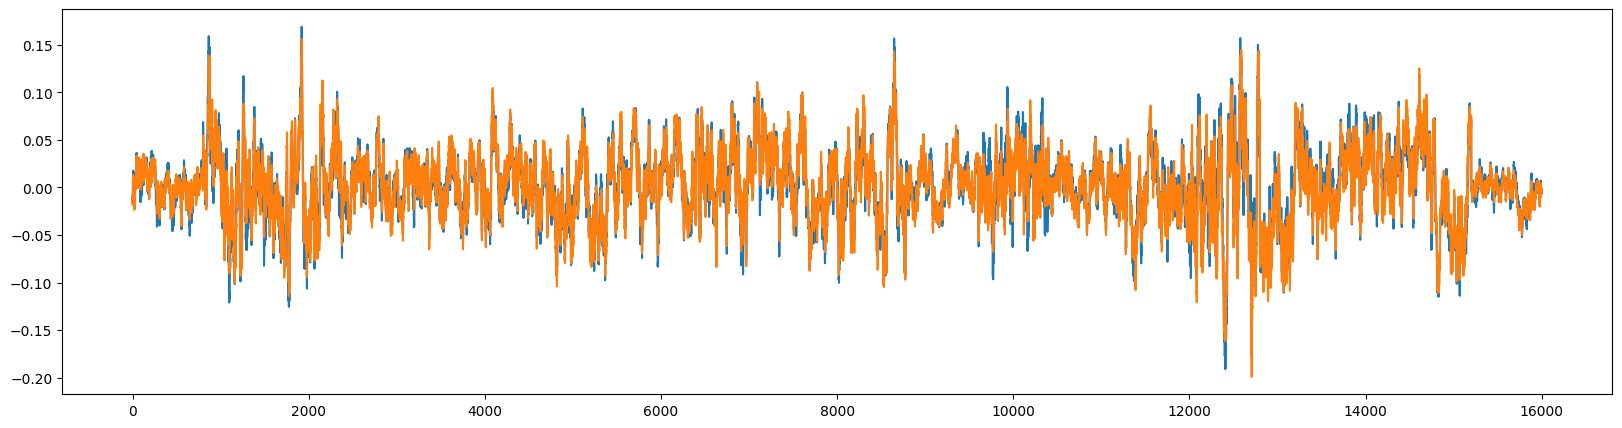

In [139]:
plt.figure(figsize=(20,5))
# plt.plot(error_noisy[:,0])
# plt.plot(error_noisy2[:,0])
plt.plot(error_clean[:,0])
plt.plot(error_clean2[:,0])

In [71]:
A = my_ESN_clean.dfdu_const.toarray()
J = [None]*16000
k = 0
for i in range(20):
    for j in np.arange(1,800):
        dtanh = my_ESN_clean.dtanh(R[i*800+j],R[i*800+j-1])
        J[k] = np.matmul(np.diag(dtanh),A)
        k += 1

In [72]:
A = my_ESN_clean.dfdu_const.toarray()
J_noisy = [None]*16000
k = 0
for i in range(20):
    for j in np.arange(1,800):
        dtanh = my_ESN_clean.dtanh(R_noisy[i*800+j],R_noisy[i*800+j-1])
        J_noisy[k] = np.matmul(np.diag(dtanh),A)
        k += 1

In [80]:
J_mean_noisy = np.mean(np.array(J_noisy[:-20]), axis = 0)
np.linalg.norm(J_mean_noisy)

0.0529102097016496

In [19]:
# get the standard deviation of noise
var_list = np.zeros((len(train_idx_list),DATA_clean["train"]["y"][0].shape[1]))
for train_idx in train_idx_list:
    var_list[train_idx] = (noise_level/100*np.std(DATA_clean["train"]["y"][train_idx],axis=0))**2
# this is different for each regime
# we need to concatenate and make a diagonal matrix
W_out_new = np.zeros_like(my_ESN_clean.W_out)
for y_idx in range(DATA_clean["train"]["y"][0].shape[1]):
    sigma_inv = np.diag(np.repeat(1/var_list[:,y_idx],DATA_clean["train"]["y"][0].shape[0]))
    RR = R_noisy.T @ sigma_inv @ R_noisy
    phi = RR+my_ESN_clean.tikhonov*np.eye(my_ESN_clean.N_reservoir)
    f = R_noisy.T @ sigma_inv @ Y_train_noisy[:,y_idx]
    W_out_new[:,y_idx] = np.linalg.solve(phi,f)

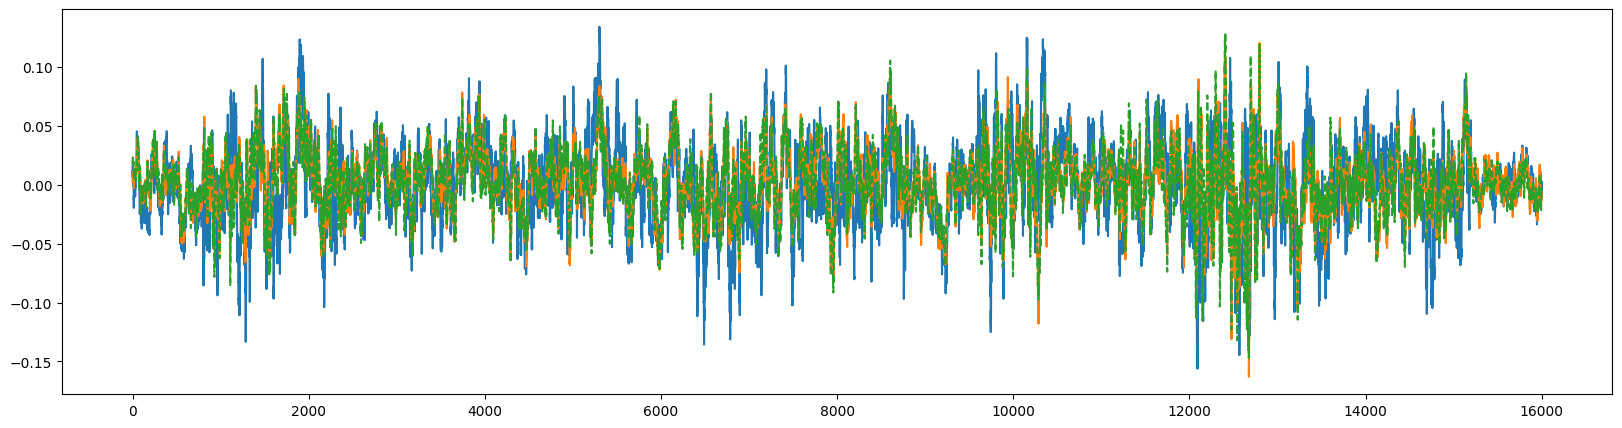

In [46]:
y_pred_clean = np.matmul(R_noisy,W_out)
y_pred_noisy = np.matmul(R_noisy,W_out_noisy)
y_pred_new = np.matmul(R_noisy,W_out_new)
plt.figure(figsize=(20,5))
plt.plot(Y_train[:,0]-y_pred_clean[:,0])
plt.plot(Y_train[:,0]-y_pred_noisy[:,0])
plt.plot(Y_train[:,0]-y_pred_new[:,0],'--')


In [51]:
print(np.linalg.norm(Y_train-y_pred_clean))
print(np.linalg.norm(Y_train-y_pred_noisy))
print(np.linalg.norm(Y_train-y_pred_new))
print(np.linalg.norm(W_out))
print(np.linalg.norm(W_out_noisy))
print(np.linalg.norm(W_out_new))

13.490337143170517
9.715305630011157
9.60446207393217
365.2880964952976
3043.0518330225104
25402.532512344787


In [55]:
# Different noise
my_ESN_clean.tau = results["training_parameters"][0][1]
my_ESN_clean.W_out = W_out
_,y_cl = my_ESN_clean.closed_loop_with_washout(U_washout=DATA_clean["train"]["u_washout"][0],P_washout=DATA_clean["train"]["p_washout"][0],
                        N_t=len(DATA_clean["train"]["u"][0]),P=DATA_clean["train"]["p"][0],)

my_ESN_clean.W_out = W_out_noisy
_,y_cl_noisy = my_ESN_clean.closed_loop_with_washout(U_washout=DATA_clean["train"]["u_washout"][0],P_washout=DATA_clean["train"]["p_washout"][0],
                        N_t=len(DATA_clean["train"]["u"][0]),P=DATA_clean["train"]["p"][0],)

my_ESN_clean.W_out = W_out_new
_,y_cl_new = my_ESN_clean.closed_loop_with_washout(U_washout=DATA_clean["train"]["u_washout"][0],P_washout=DATA_clean["train"]["p_washout"][0],
                        N_t=len(DATA_clean["train"]["u"][0]),P=DATA_clean["train"]["p"][0],)

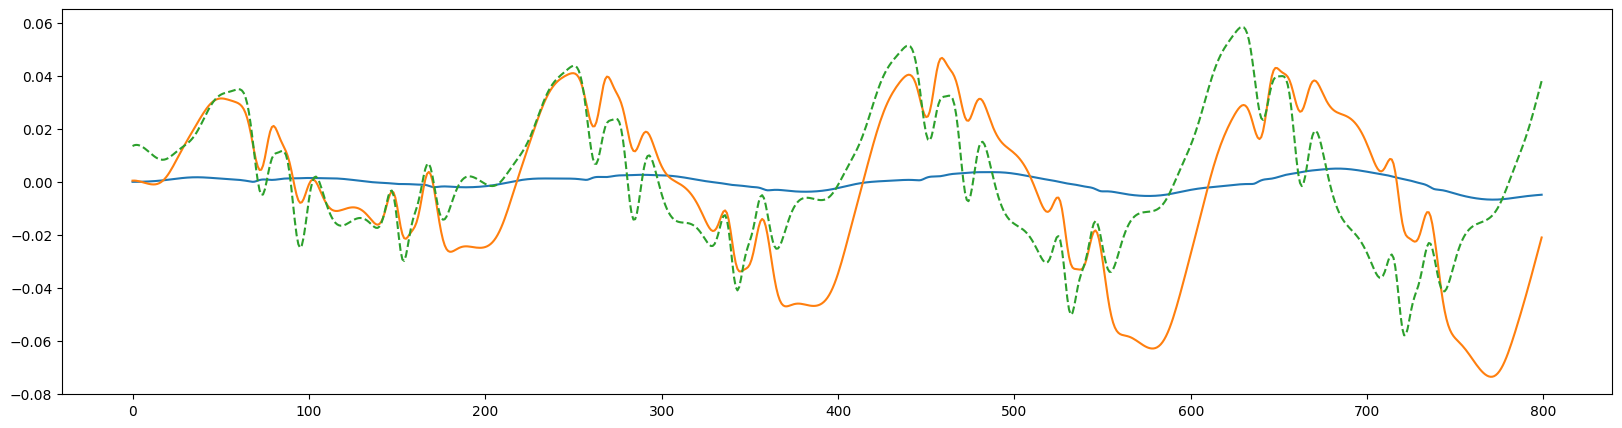

In [58]:
plt.figure(figsize=(20,5))
plt.plot(DATA_clean["train"]["y"][0][:,0]-y_cl[1:,0])
plt.plot(DATA_clean["train"]["y"][0][:,0]-y_cl_noisy[1:,0])
plt.plot(DATA_clean["train"]["y"][0][:,0]-y_cl_new[1:,0],'--')


In [268]:
t = np.arange(0,10,0.01)
u = np.sin(t)+np.sin(10*t)
A = np.array([[0.1,0.1,0.0],[0.0,0.1,0.1],[0.0,0.0,1.0]])
B = np.array([1.0,1.0,1.0])
r_lin = np.zeros((3,len(t)))
r = np.zeros((3,len(t)))
for k in np.arange(1,len(t)):
    r[:,k] = np.tanh(A @ r[:,k-1] +  B * u[k-1])
    r_lin[:,k] = A @ r[:,k-1] +  B * u[k-1]

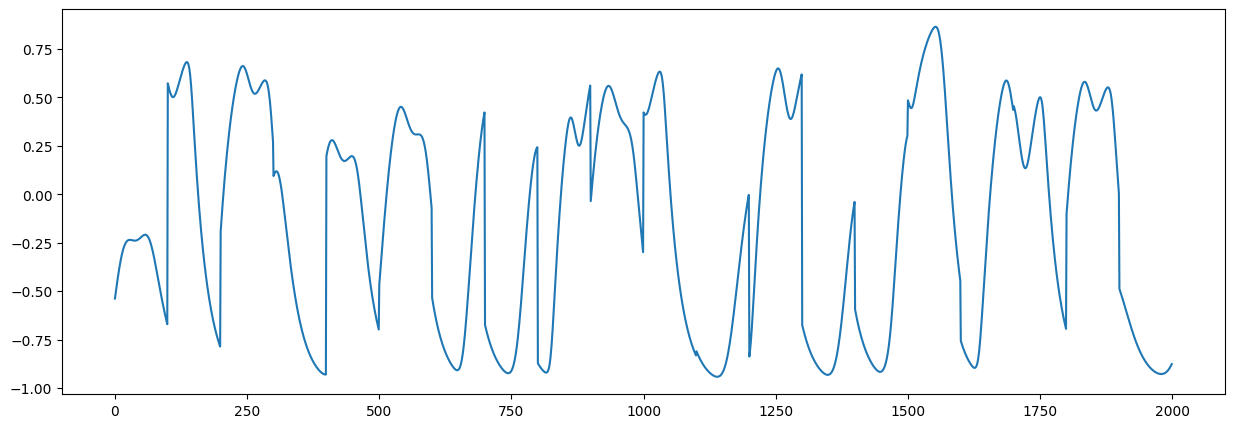

In [290]:
plt.figure(figsize=(15,5))
plt.plot(R[:,-133])